In [ ]:
import pandas as pd 
import numpy as np
import os
from os import walk
import statistics
from matplotlib import pyplot as pt
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mannwhitneyu
import math 
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from tqdm.notebook import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
#from google.colab import drive

#drive.mount('/content/gdrive')
import pickle

In [ ]:
# Getting back the objects:
with open('preprocessing.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    df_feat, df_nft, df, pd_patients = pickle.load(f)

In [ ]:
#df_demo = pd.read_excel ("/content/drive/MyDrive/TFM/i-PROGNOSIS_DS2.5_Sub1_KeystrokeTimingPressureData/Demographics_Clinical_Characteristics.xlsx")
df_demo = pd.read_excel ("/Users/mariabaeza/Desktop/Universidad/BigData/TFM/i-PROGNOSIS_DS2.5_Sub1_KeystrokeTimingPressureData/Demographics_Clinical_Characteristics.xlsx")
df_demo

,Subject ID,Age (years),Gender,Education level,Years of smartphone usage,Dominant hand,Group,Years from diagnosis,Hoehn & Yahr stage,Most affected side (PD patients only),Levodopa Equivalent Daily Dose (LEDD) (mg),UPDRS_III Total score,UPDRS_III Item 21 Tremor-Right hand,UPDRS_III Item 21 Tremor-Left hand,UPDRS_III Item 22 Rigidity-Right hand,UPDRS_III Item 22 Rigidity-Left hand,UPDRS_III Item 23 Finger Taps-Right hand,UPDRS_III Item 23 Finger Taps-Left hand,UPDRS_III Item 31 Body Bradykinesia/Hypokinesia
0,1,69,Male,High school graduate,3,Right,PD,3,2,Right,0,5,1,0,1,0,1,0,0
1,2,61,Female,High school graduate,3,Right,PD,6,2,Left,360,21,1,2,1,2,1,2,1
2,3,65,Male,High school graduate,3,Right,PD,5,2,Left,402,19,0,0,1,2,1,2,1
3,4,51,Male,University graduate,2,Right,PD,1,1,Right,240,8,0,0,1,0,1,0,0
4,5,63,Male,University graduate,6,Right,PD,3,2,Left,255,28,1,2,1,2,2,2,1
5,6,78,Male,University graduate,3,Right,PD,5,2,Right,500,27,1,1,2,2,2,2,2
6,7,53,Male,University graduate,3,Right,PD,1,2,Right,0,22,0,1,1,2,1,2,1
7,8,43,Male,University graduate,6,Right,PD,2,1,Right,100,12,1,0,1,0,2,0,0
8,9,66,Male,University graduate,7,Right,PD,1,1,Right,0,3,1,0,1,0,1,0,0
9,10,62,Male,University graduate,2,Right,PD,5,2,Right,205,26,1,0,2,1,2,2,2


(-1.1102851077195106,
 1.1209288414887717,
 -1.1084174822899142,
 1.1004008324899959)

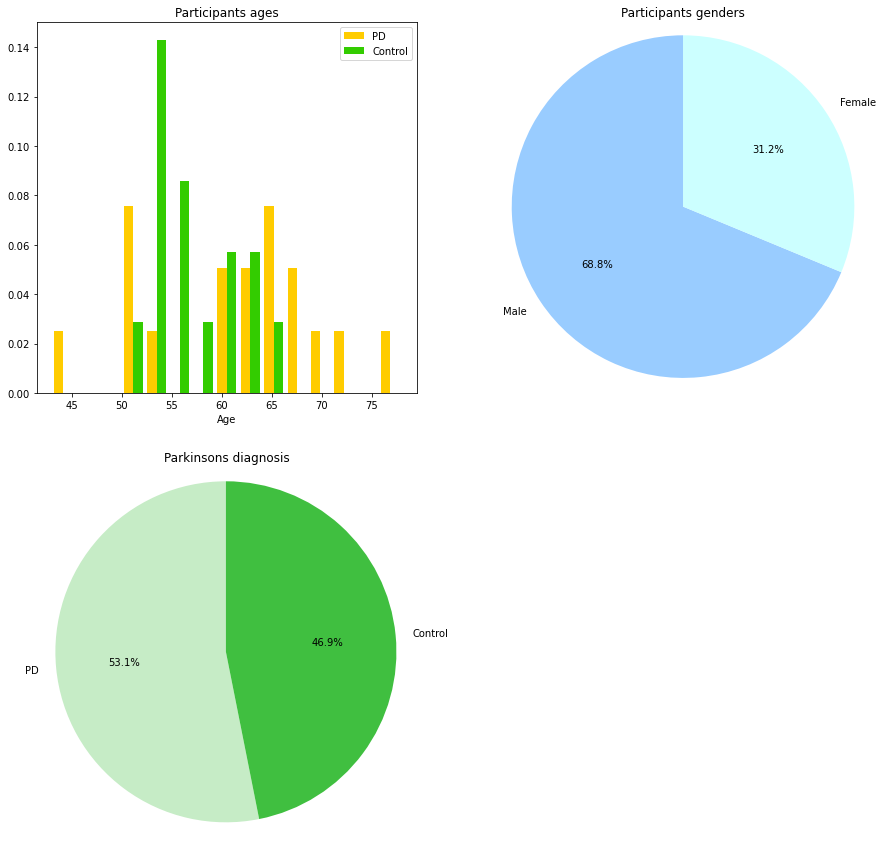

In [ ]:
# AGES sick vs healthy
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 2, 1, title="Participants ages")
ax.hist([df_demo["Age (years)"][(df_demo.Group == "PD")], df_demo["Age (years)"][(df_demo.Group == "Control")]], bins=15, histtype='bar',
        color=['#FFCC00', '#33CC00'], density=True)
ax.set_xlabel("Age")
ax.set_ylabel("")
ax.legend(["PD", "Control"])


ax = fig.add_subplot(2, 2, 2, title="Participants genders")
ax.pie(df_demo.Gender.value_counts(), labels=["Male", "Female"], colors=["#99CCFF", "#CCFFFF"],
       startangle=90, autopct='%1.1f%%')
ax.axis('equal')

ax = fig.add_subplot(2, 2, 3, title="Parkinsons diagnosis")
ax.pie(df_demo.Group.value_counts(), labels=["PD", "Control"], colors=["#c6ecc6", "#40bf40"],
       startangle=90, autopct='%1.1f%%')
ax.axis('equal')

In [ ]:
from sklearn.preprocessing import LabelEncoder
temp_df = df_demo.copy()
temp_df['Gender'] = LabelEncoder().fit_transform(temp_df['Gender'])
temp_df['Dominant hand'] = LabelEncoder().fit_transform(temp_df['Dominant hand'])
temp_df['Group'] = LabelEncoder().fit_transform(temp_df['Group'])
temp_df['Education level'] = LabelEncoder().fit_transform(temp_df['Education level'])
temp_df
temp_df.corr()['Group'].sort_values(ascending=False)


Group                                              1.000000
Hoehn & Yahr stage                                 0.920734
UPDRS_III Item 23 Finger Taps-Right hand           0.895948
UPDRS_III Item 22 Rigidity-Right hand              0.895948
UPDRS_III Total score                              0.820015
UPDRS_III Item 21 Tremor-Right hand                0.727607
Years from diagnosis                               0.716833
Levodopa Equivalent Daily Dose (LEDD) (mg)         0.666208
UPDRS_III Item 31 Body Bradykinesia/Hypokinesia    0.664211
UPDRS_III Item 23 Finger Taps-Left hand            0.611712
UPDRS_III Item 22 Rigidity-Left hand               0.602272
UPDRS_III Item 21 Tremor-Left hand                 0.377744
Age (years)                                        0.325625
Gender                                             0.312428
Years of smartphone usage                          0.167633
Education level                                   -0.231756
Subject ID                              

In [ ]:
def obtain_corr(df_input):
    cc_HY = np.zeros(df_input.shape[1]-1)
    cc_UPDRS = np.zeros(df_input.shape[1]-1)
    cc_UPDRS_R = np.zeros(df_input.shape[1]-1)
    cc_UPDRS_L = np.zeros(df_input.shape[1]-1)
    p_HY = np.zeros(df_input.shape[1]-1)
    p_UPDRS = np.zeros(df_input.shape[1]-1)
    p_UPDRS_R = np.zeros(df_input.shape[1]-1)
    p_UPDRS_L = np.zeros(df_input.shape[1]-1)
    dff = df_input.groupby("SubjectID").mean()
    for i in list(range(0,df_input.shape[1]-1)):
        cc_HY[i],p_HY[i] = spearmanr(df_demo.iloc[:,8],dff.iloc[:,i])
        cc_UPDRS[i],p_UPDRS[i] = spearmanr(df_demo.iloc[:,11],dff.iloc[:,i])
        cc_UPDRS_R[i],p_UPDRS_R[i] = spearmanr(df_demo.iloc[:,16],dff.iloc[:,i])
        cc_UPDRS_L[i],p_UPDRS_L[i] = spearmanr(df_demo.iloc[:,17],dff.iloc[:,i])
        
    rho = pd.DataFrame()
    rho = rho.append(pd.Series(cc_HY, name="HY"))
    rho = rho.append(pd.Series(cc_UPDRS, name="UPDRS"))
    rho = rho.append(pd.Series(cc_UPDRS_R, name="UPDRS_R"))
    rho = rho.append(pd.Series(cc_UPDRS_L,name="UPDRS_L"))
    
    pval = pd.DataFrame()
    pval = pval.append(pd.Series(p_HY, name="HY"))
    pval = pval.append(pd.Series(p_UPDRS, name="UPDRS"))
    pval = pval.append(pd.Series(p_UPDRS_R, name="UPDRS_R"))
    pval = pval.append(pd.Series(p_UPDRS_L,name="UPDRS_L"))
    rho.columns=df_input.columns[0:-1]
    pval.columns=df_input.columns[0:-1]
    
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.05] if x<=t]))
    prueba = rho.round(2).astype(str) + p

    return prueba
    

In [ ]:
NP_corr = obtain_corr(df_NP)
NP_corr

,NP Mean,NP Median,NP SD,NP Skewness,NP Kurtosis,NP SD Mean,NP SD Median,NP SD SD,NP SD Skewness,NP SD Kurtosis
HY,-0.59***,-0.59***,-0.27,0.49**,-0.54**,0.36*,0.53**,0.12,0.35,-0.32
UPDRS,-0.62***,-0.63***,-0.22,0.55**,-0.57***,0.37*,0.58***,0.13,0.34,-0.37*
UPDRS_R,-0.6***,-0.61***,-0.3,0.62***,-0.55**,0.3,0.51**,0.0,0.33,-0.4*
UPDRS_L,-0.56***,-0.55**,-0.08,0.36*,-0.39*,0.31,0.49**,0.19,0.3,-0.19


In [ ]:
HT_corr = obtain_corr(df_HT)
HT_corr

,HT Mean,HT Median,HT SD,HT Skewness,HT Kurtosis,HT SD Mean,HT SD Median,HT SD SD,HT SD Skewness,HT SD Kurtosis
HY,0.47**,0.47**,0.58***,0.19,-0.38*,0.57***,0.49**,0.62***,0.33,-0.17
UPDRS,0.51**,0.52**,0.65***,0.22,-0.34,0.6***,0.51**,0.68***,0.34,-0.08
UPDRS_R,0.6***,0.6***,0.68***,0.39*,-0.33,0.64***,0.54**,0.7***,0.22,-0.07
UPDRS_L,0.27,0.28,0.47**,0.02,-0.22,0.38*,0.33,0.49**,0.44*,-0.09


In [ ]:
NFT_corr = obtain_corr(df_NFT)
NFT_corr

,NFT Mean,NFT Median,NFT SD,NFT Skewness,NFT Kurtosis,NFT SD Mean,NFT SD Median,NFT SD SD,NFT SD Skewness,NFT SD Kurtosis
HY,-0.28,-0.23,0.44*,-0.53**,-0.57***,0.57***,0.55**,0.57***,-0.11,-0.55**
UPDRS,-0.26,-0.18,0.41*,-0.51**,-0.55**,0.57***,0.55**,0.57***,-0.08,-0.52**
UPDRS_R,-0.26,-0.17,0.32,-0.48**,-0.49**,0.54**,0.49**,0.56***,0.04,-0.43*
UPDRS_L,-0.12,-0.04,0.34,-0.47**,-0.47**,0.42*,0.43*,0.38*,-0.09,-0.5**


In [ ]:
V_corr = obtain_corr(df_v)
V_corr

,Velocity Mean,Velocity Median,Velocity SD,Velocity Skewness,Velocity Kurtosis,Velocity SD Mean,Velocity SD Median,Velocity SD SD,Velocity SD Skewness,Velocity SD Kurtosis
HY,-0.62***,-0.61***,-0.58***,0.26,-0.59***,-0.34,-0.32,-0.47**,-0.52**,-0.3
UPDRS,-0.6***,-0.59***,-0.56***,0.23,-0.57***,-0.32,-0.29,-0.48**,-0.5**,-0.38*
UPDRS_R,-0.56***,-0.55***,-0.51**,0.16,-0.53**,-0.28,-0.28,-0.43*,-0.47**,-0.36*
UPDRS_L,-0.48**,-0.48**,-0.48**,0.27,-0.47**,-0.3,-0.26,-0.4*,-0.41*,-0.29


In [ ]:
A_corr = obtain_corr(df_a)
A_corr

,Acceleration Mean,Acceleration Median,Acceleration SD,Acceleration Skewness,Acceleration Kurtosis,Acceleration SD Mean,Acceleration SD Median,Acceleration SD SD,Acceleration SD Skewness,Acceleration SD Kurtosis
HY,-0.62***,-0.62***,-0.6***,-0.24,-0.59***,-0.48**,-0.44*,-0.48**,-0.5**,-0.27
UPDRS,-0.6***,-0.6***,-0.58***,-0.27,-0.58***,-0.44*,-0.4*,-0.47**,-0.48**,-0.36*
UPDRS_R,-0.56***,-0.56***,-0.56***,-0.35*,-0.52**,-0.43*,-0.4*,-0.45*,-0.45*,-0.34
UPDRS_L,-0.48**,-0.48**,-0.45**,-0.11,-0.48**,-0.34,-0.3,-0.36*,-0.4*,-0.28


In [ ]:
PC_corr = obtain_corr(df_pc)
PC_corr

,PChange Mean,PChange Median,PChange SD,PChange Skewness,PChange Kurtosis,PChange SD Mean,PChange SD Median,PChange SD SD,PChange SD Skewness,PChange SD Kurtosis
HY,-0.2,-0.05,-0.28,0.24,-0.55**,0.37*,0.36*,0.21,0.22,-0.24
UPDRS,-0.23,-0.15,-0.23,0.33,-0.58***,0.37*,0.4*,0.21,0.17,-0.29
UPDRS_R,-0.19,-0.13,-0.3,0.26,-0.52**,0.33,0.3,0.15,0.16,-0.19
UPDRS_L,-0.22,-0.19,-0.1,0.27,-0.44*,0.27,0.33,0.21,0.15,-0.29


In [ ]:
PJ_corr = obtain_corr(df_pj)
PJ_corr

,PJerk Mean,PJerk Median,PJerk SD,PJerk Skewness,PJerk Kurtosis,PJerk SD Mean,PJerk SD Median,PJerk SD SD,PJerk SD Skewness,PJerk SD Kurtosis
HY,-0.32,0.29,-0.29,-0.46**,-0.54**,0.52**,0.57***,0.22,0.54**,-0.24
UPDRS,-0.18,0.34,-0.25,-0.49**,-0.55***,0.52**,0.6***,0.23,0.5**,-0.26
UPDRS_R,-0.18,0.42*,-0.32,-0.58***,-0.53**,0.48**,0.51**,0.18,0.47**,-0.19
UPDRS_L,-0.16,0.18,-0.1,-0.31,-0.38*,0.44*,0.54**,0.18,0.42*,-0.2
